# CS 109A/AC 209A/STAT 121A Data Science: Airbnb Project
## Step 4 - Text Analysis Model for Description
**Harvard University**  
**Fall 2016**  
**Team**: Stephen Camera-Murray, Himani Garg, and Vijay Thangella  
**TF**: Christine Hwang  
  
**Due Date: ** Wednesday, December 14th, 2016 at 11:59pm

### Text Description Recommendations

Import libraries

In [300]:
# import libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random
from sklearn.linear_model import LogisticRegression  as LogReg
from PIL import Image
# suppress warnings
import matplotlib.image as mpimg
warnings.filterwarnings ( 'ignore' )
%matplotlib inline
import os 
import nltk
import re
import time
import nltk.tag.stanford as st
from nltk.corpus import stopwords # Import the stop word list
from sklearn.feature_extraction.text import CountVectorizer        
from nltk.stem.porter import PorterStemmer
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier 
import sklearn.grid_search as gs
from sklearn.cross_validation import cross_val_score
import seaborn as sns
import heapq
from sklearn.svm import SVC
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler as Standardize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree

We begin by loading the listings dataset we saved after cleansing from milestone #4:  
- cleansed_listings.csv.gz - the New York City Airbnb listing data from January 2015 (cleansed)

In [251]:
# load listings data into a pandas df
listingsDF = pd.read_csv (  './datasets/cleansed_listings_with_target.tab.gz', sep = '\t', index_col = 'id', compression = 'gzip' )

# display the first two rows
listingsDF.head ( n = 2 )

,name,neighborhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,months_as_host,months_since_first_review,months_since_last_review,price_category
id,,,,,,,,,,,,,,,,,,,,,
1069266,Stay like a real New Yorker!,Midtown East,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,1.0,...,7.0,9.0,9.0,10.0,9.0,1,21,21,1,Mid
2061725,Option of 2 Beds w Private Bathroom,Bushwick,Apartment,Private room,2,1.0,1.0,2.0,Real Bed,1.0,...,10.0,10.0,10.0,9.0,10.0,4,24,11,1,Low


** DATA EXPLORATION **

In [252]:
listingsDF.shape

(19526, 30)

** A new column high price  has been created by combining high and medium class**

In [253]:
listingsDF['high_price'] = np.where(listingsDF['price_category']=='Low', 0, 1)
listingsDF.head(n=5)

,name,neighborhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,months_as_host,months_since_first_review,months_since_last_review,price_category,high_price
id,,,,,,,,,,,,,,,,,,,,,
1069266,Stay like a real New Yorker!,Midtown East,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,1.0,...,9.000000,9.00000,10.000000,9.000000,1,21,21,1,Mid,1
2061725,Option of 2 Beds w Private Bathroom,Bushwick,Apartment,Private room,2,1.0,1.0,2.0,Real Bed,1.0,...,10.000000,10.00000,9.000000,10.000000,4,24,11,1,Low,0
44974,Charming Bright West Village Studio,West Village,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,1.0,...,10.000000,10.00000,10.000000,9.000000,1,53,51,3,Mid,1
4701675,Charming Apartment in Chelsea,Chelsea,Apartment,Entire home/apt,2,1.0,1.0,2.0,Real Bed,1.0,...,10.000000,10.00000,10.000000,10.000000,1,3,1,1,Mid,1
4832596,Large furnished sunny room,Bushwick,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,1.0,...,9.584855,9.67541,9.246366,9.140759,1,26,0,63,Low,0


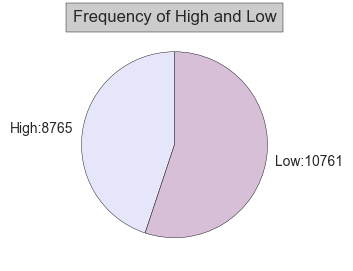

In [254]:
#plot a pie chart to see ratio between positve and negative opinion 
fig = plt.figure(figsize=(3,3))
plt.title('Frequency of High and Low', bbox={'facecolor':'0.8', 'pad':5})

# The slices will be ordered and plotted counter-clockwise.
# define dataset

High  = (listingsDF['high_price']==1).sum()

Low = (listingsDF['high_price']==0).sum()

fractionsc = [High,Low]
# The slices will be ordered and plotted counter-clockwise.
labels = 'High:'+str(High), 'Low:'+str(Low)

# plt the pie 
plt.pie( fractionsc,  
                  colors=['lavender', 'thistle'],
                 labels=labels,
               shadow=False, startangle=90)

plt.show()






** As per pie chart the classes seems not to be highly imbalance, enough data points are present for both the classes for training the model**

In [255]:
listingsDF['name'][0:40] 

id
1069266          Stay like a real New Yorker! 
2061725    Option of 2 Beds w Private Bathroom
44974      Charming Bright West Village Studio
4701675          Charming Apartment in Chelsea
4832596             Large furnished sunny room
2562510      2 br Private Room in LI/Chinatown
1322641       Beautiful 1100ft - Furnished Apt
4833061                               Bushwick
2000287     Fabulous Fall GTWY Eastern Parkway
2525956    Beautiful 1 Bdr in the heart of NYC
809929         Clean and Cozy West Village Apt
753622        1 Private Bedroom / East Village
1781041    Beautiful Apt. - 15 min. to Midtown
4323940    Sanctuary by Prospect Park w/ Sauna
1832976           Convenient Downtown location
4218098     1 bedroom apt CentralPark-Columbia
4053471      Apartment in Heart of Greenpoint 
4831993    HUGE BR w/Bathroom in LUX Apt. Bldg
2596813    UWS Near #1, Columbia U, St. John's
4810267                Trendy NoLita Apartment
4358437     Gorgeous-w/Balcony-Airport Pick up
26229     

 Above dataset has many problems like punctuation,capitalization, all the different neighborhoods have been replaced to space.The reason behind doing this is that we want  to see what other words apart from neighborhood are helpful  for high listings. Also there are many words similar like apt and apartment  , min and mins which have high frequencies compare to other words so it has been changed to apartment and minutes. 
 
 
 

It seems data has issues of typo like 'appartement' ,'appartment' to correct that tried to install the Speller Check of pyenchant library but its only available for 32 bit so we have change the data above for most frequent words as above.

In [256]:
# Clean the dataset
neighborhood = set(listingsDF['neighborhood'].values)


#Replace all the neighborhood 
for word in neighborhood: 
    listingsDF['name'] = listingsDF['name'].str.replace(word, '')
# replace all the non alphanumeric characters    
listingsDF['name'] = listingsDF['name'].str.replace("[^a-zA-Z]", " ")
# convert the text into lower
listingsDF['name'] = listingsDF['name'].str.lower()
# convert apt into apartment 
listingsDF['name'] = listingsDF['name'].str.replace(" apt ", " apartment ") 
listingsDF['name'] = listingsDF['name'].str.replace(" train  ", " trains ") 
listingsDF['name'] = listingsDF['name'].str.replace(" mins  ", " minutes ")
listingsDF['name'] = listingsDF['name'].str.replace(" apartm  ", " apartment ")
listingsDF['name'] = listingsDF['name'].str.replace(" appartment  ", " apartment ")
listingsDF['name'] = listingsDF['name'].str.replace("appartment", "")
listingsDF['name'] = listingsDF['name'].str.replace("apartm  ", "")

listingsDF['name'][0:40]  
    
  

id
1069266                stay like a real new yorker  
2061725          option of   beds w private bathroom
44974                        charming bright  studio
4701675                       charming apartment in 
4832596                   large furnished sunny room
2562510                       br private room in li 
1322641             beautiful     ft   furnished apt
4833061                                             
2000287           fabulous fall gtwy eastern parkway
2525956          beautiful   bdr in the heart of nyc
809929                           clean and cozy  apt
753622                            private bedroom   
1781041           beautiful apartment       min  to 
4323940          sanctuary by prospect park w  sauna
1832976                 convenient downtown location
4218098       bedroom apartment centralpark columbia
4053471                      apartment in heart of  
4831993    huge br w bathroom in lux apartment  bldg
2596813          uws near     columbia u  s

Next step is to remove all the words like singular letters, prepositions that  are not required for the analysis " Stop words"

In [257]:
# check all the stop words
stops = set(stopwords.words("english"))
# Add all other words whch are singular 
stops = stops | set(['w','br','wth','x','rm','nyc','bd','bdrm','gr','f','ap','b','c','d','e','f','g','h','j','k','l','m','n','o','p','q','r','s','t','u','v','y','z','apt','one','sep','fr','dm','ba','pl','ev','rr'])
#check the stop list
print stops

set([u'all', 'gr', u'just', u'being', u'over', u'through', u'during', u'its', u'before', 'one', u'hadn', u'with', u'll', u'had', u'should', u'to', u'only', u'does', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'yourselves', u'now', u'him', u'nor', u'd', u'did', 'h', u'didn', 'l', u'these', u'she', u'each', 'x', u'where', 'e', u'because', 'sep', u'doing', u'theirs', u'some', u'we', u'up', u'are', u'further', 'ev', u'ourselves', u'out', u'what', 'u', u'for', 'p', u'weren', u're', u'won', u'above', u'between', 'rm', u'mustn', u't', 'bd', u'be', u'hasn', u'after', 'ba', 'v', u'here', u'shouldn', 'br', u'hers', 'r', u'by', u'both', u'about', u'couldn', 'g', u'of', 'k', u'o', u's', u'isn', 'w', u'or', 'dm', u'own', u'into', 'apt', u'yourself', u'down', 'wth', u'mightn', u'wasn', u'your', u'from', u'her', u'their', u'aren', u'there', u'been', u'few', u'too', u'then', u'themselves', u'was', u'until', 'pl', u'more', u'himself', u'on', 'c', u'but', u'off', u'hers

Preparing a corpus


A corpus or text corpus is a large and structured set of texts . They are used to do statistical analysis and hypothesis testing, checking occurrences or validating linguistic rules within a specific language territory. In our case, we are talking about the collection of text fragments that we want to classify in either high or low listing.
The method fit_transform does two functions: First, it fits the model and learns the vocabulary; second, it transforms our corpus data into feature vectors

In [258]:
def vector_fit(corpus, min_df):
##Display feature names##
#Convert a collection of text documents to a matrix of token counts#

    vectorizer = CountVectorizer( lowercase = True,stop_words = stops
                             ,min_df= min_df, token_pattern=r'\b\w+\b')
    corpus_data_features = vectorizer.fit_transform(corpus)
    corpus_data_array = corpus_data_features.toarray()
    return  vectorizer.get_feature_names(), corpus_data_array


#function call for whole data
feature_name , x = vector_fit(listingsDF['name'].values,4)
y = listingsDF['high_price'].values
print feature_name[0:25]






[u'abode', u'ac', u'access', u'across', u'action', u'adorable', u'affordable', u'airport', u'airy', u'alcove', u'alphabet', u'amazing', u'amazingly', u'amenities', u'amsterdam', u'apart', u'apartm', u'apartmen', u'apartment', u'appartement', u'apple', u'architect', u'area', u'art', u'artist']


In [259]:
#function call to get no of words
_ , x_u = vector_fit(listingsDF['name'].values,1)

Pos_df = listingsDF.loc[listingsDF['high_price']==1]
feature_name_pos ,x_pos = vector_fit(Pos_df['name'].values,1)

Neg_df= listingsDF.loc[listingsDF['high_price']==0]
feature_name_neg  ,x_neg = vector_fit(Neg_df['name'].values,1)

x_hicount = x_pos.shape[1]
x_lowcount = x_neg.shape[1]

print 'Number of non unique words (features) used :', x_u.shape[1]
print '\nNumber of words non unique (features) used in for identifying high price:', x_hicount
print '\n Number of words non unique (features) used in for identifying low price: ', x_lowcount


Number of non unique words (features) used : 3056

Number of words non unique (features) used in for identifying high price: 1887

 Number of words non unique (features) used in for identifying low price:  2279


The min_df value has been set as 4 because it was givng the the best accuracy score , if the value was increased or decreased the accuracy score was getting down. 

In [260]:

# to visualise get the array of positive and negative 
Pos_df = listingsDF.loc[listingsDF['high_price']==1]
feature_name_pos ,x_pos = vector_fit(Pos_df['name'].values,4)

Neg_df= listingsDF.loc[listingsDF['high_price']==0]
feature_name_neg ,x_neg = vector_fit(Neg_df['name'].values,4)

print 'Number of words (features) used :', x.shape[1]
print '\nNumber of words (features) used in for identifying high price:', x_pos.shape[1]
print '\n Number of words (features) used in for identifying low price: ', x_neg.shape[1]

Number of words (features) used : 916

Number of words (features) used in for identifying high price: 566

 Number of words (features) used in for identifying low price:  681


From our corpus we can see we have only 916 meaningful unique words . For high Listing its :566 and for low income:681
There seems to be significant amount of overlapping of words in both the clasess. 


In [261]:
# function to create datset of words  with counts in high ,low ,total

def df_list(x_srt , feature):
    dist = np.sum(x_srt, axis=0)
    

    # initializse list
    word_list = []
    count_list=[]
    # get the count and feature name
    for tag, count in zip(feature , dist):
    
    # apeend the list with count and feature name
        word_list.append(tag)
        count_list.append(count)
        
    # create dataset
    df = pd.DataFrame()
    df['word'] = word_list
    df['count'] = count_list
    #return dataset
    return df

** Let's check the frequencies of all the words across all the classes  '

In [250]:
# Create dataset will all stats counts ,frequency
# return dataset of  total ,hihg , low
df_total = df_list(x , feature_name)
df_high = df_list(x_pos , feature_name_pos)
df_low = df_list(x_neg , feature_name_neg)

# join the dataset total with high and low dataset using left outer join
new_df = pd.merge(df_total, df_high, on='word', how='left')
final_word_df = pd.merge(new_df, df_low, on='word', how='left')
# replace the 'Nan with 0'
final_word_df.fillna(0, inplace=True)
final_word_df[['count_y', 'count']] = final_word_df[['count_y', 'count']].astype(int)
#Rename the default columns to readable columns
final_word_df.rename(columns={'count_x': 'Total_Count', 'count_y': 'High_Count', 'count': 'Low_Count'}, inplace=True)

# Get the frequencies
final_word_df["High_freq"]= final_word_df['High_Count']/x_hicount
final_word_df["Low_freq"]= final_word_df['Low_Count']/x_lowcount
final_word_df["High - Low"] = (final_word_df["High_freq"]- final_word_df["Low_freq"])*100
 
final_word_df.head()

,word,Total_Count,High_Count,Low_Count,High_freq,Low_freq,High - Low
0,abode,21,7,14,0.00371,0.006143,-0.243345
1,ac,13,1,12,0.00053,0.005265,-0.473553
2,access,30,8,22,0.00424,0.009653,-0.541382
3,across,15,4,11,0.00212,0.004827,-0.270691
4,action,4,2,2,0.00106,0.000878,0.018231


In [262]:
# For each, print the vocabulary word and the number of times it and sort them in desecnding order based on count 
# appears in the data set for full, neg ,pos datastet
def sort_list(x_srt , feature):
    dist = np.sum(x_srt, axis=0)
    

# initializse list
    word_list = []
# get the count and feature name
    for tag, count in zip(feature , dist):
        
 
         word_list.append((tag,count))
# sort the list        
    word_list.sort(key=itemgetter(1), reverse=True)
    return  word_list
# print the list

word_list = sort_list(x , feature_name)
word_list_pos = sort_list(x_pos , feature_name_pos)
word_list_neg = sort_list(x_neg , feature_name_neg)
print "full datset word list:", word_list[1:20]
print('\n')
print "Pos datset word list:", word_list_pos[1:20]
print('\n')
print "Neg datset word list:", word_list_neg[1:20]

full datset word list: [(u'apartment', 3856), (u'bedroom', 3063), (u'private', 2543), (u'cozy', 1624), (u'spacious', 1277), (u'sunny', 1256), (u'loft', 1097), (u'beautiful', 1063), (u'large', 974), (u'park', 880), (u'studio', 880), (u'great', 752), (u'charming', 733), (u'location', 722), (u'luxury', 721), (u'central', 652), (u'heart', 639), (u'bed', 605), (u'near', 588)]


Pos datset word list: [(u'bedroom', 1414), (u'spacious', 600), (u'loft', 589), (u'room', 582), (u'studio', 570), (u'beautiful', 544), (u'private', 543), (u'luxury', 527), (u'cozy', 486), (u'sunny', 481), (u'park', 430), (u'charming', 425), (u'large', 412), (u'location', 405), (u'heart', 401), (u'central', 376), (u'modern', 347), (u'great', 318), (u'bed', 280)]


Neg datset word list: [(u'private', 2000), (u'bedroom', 1649), (u'apartment', 1636), (u'cozy', 1138), (u'sunny', 775), (u'spacious', 677), (u'large', 562), (u'beautiful', 519), (u'loft', 508), (u'park', 450), (u'great', 434), (u'near', 349), (u'bed', 325), (u

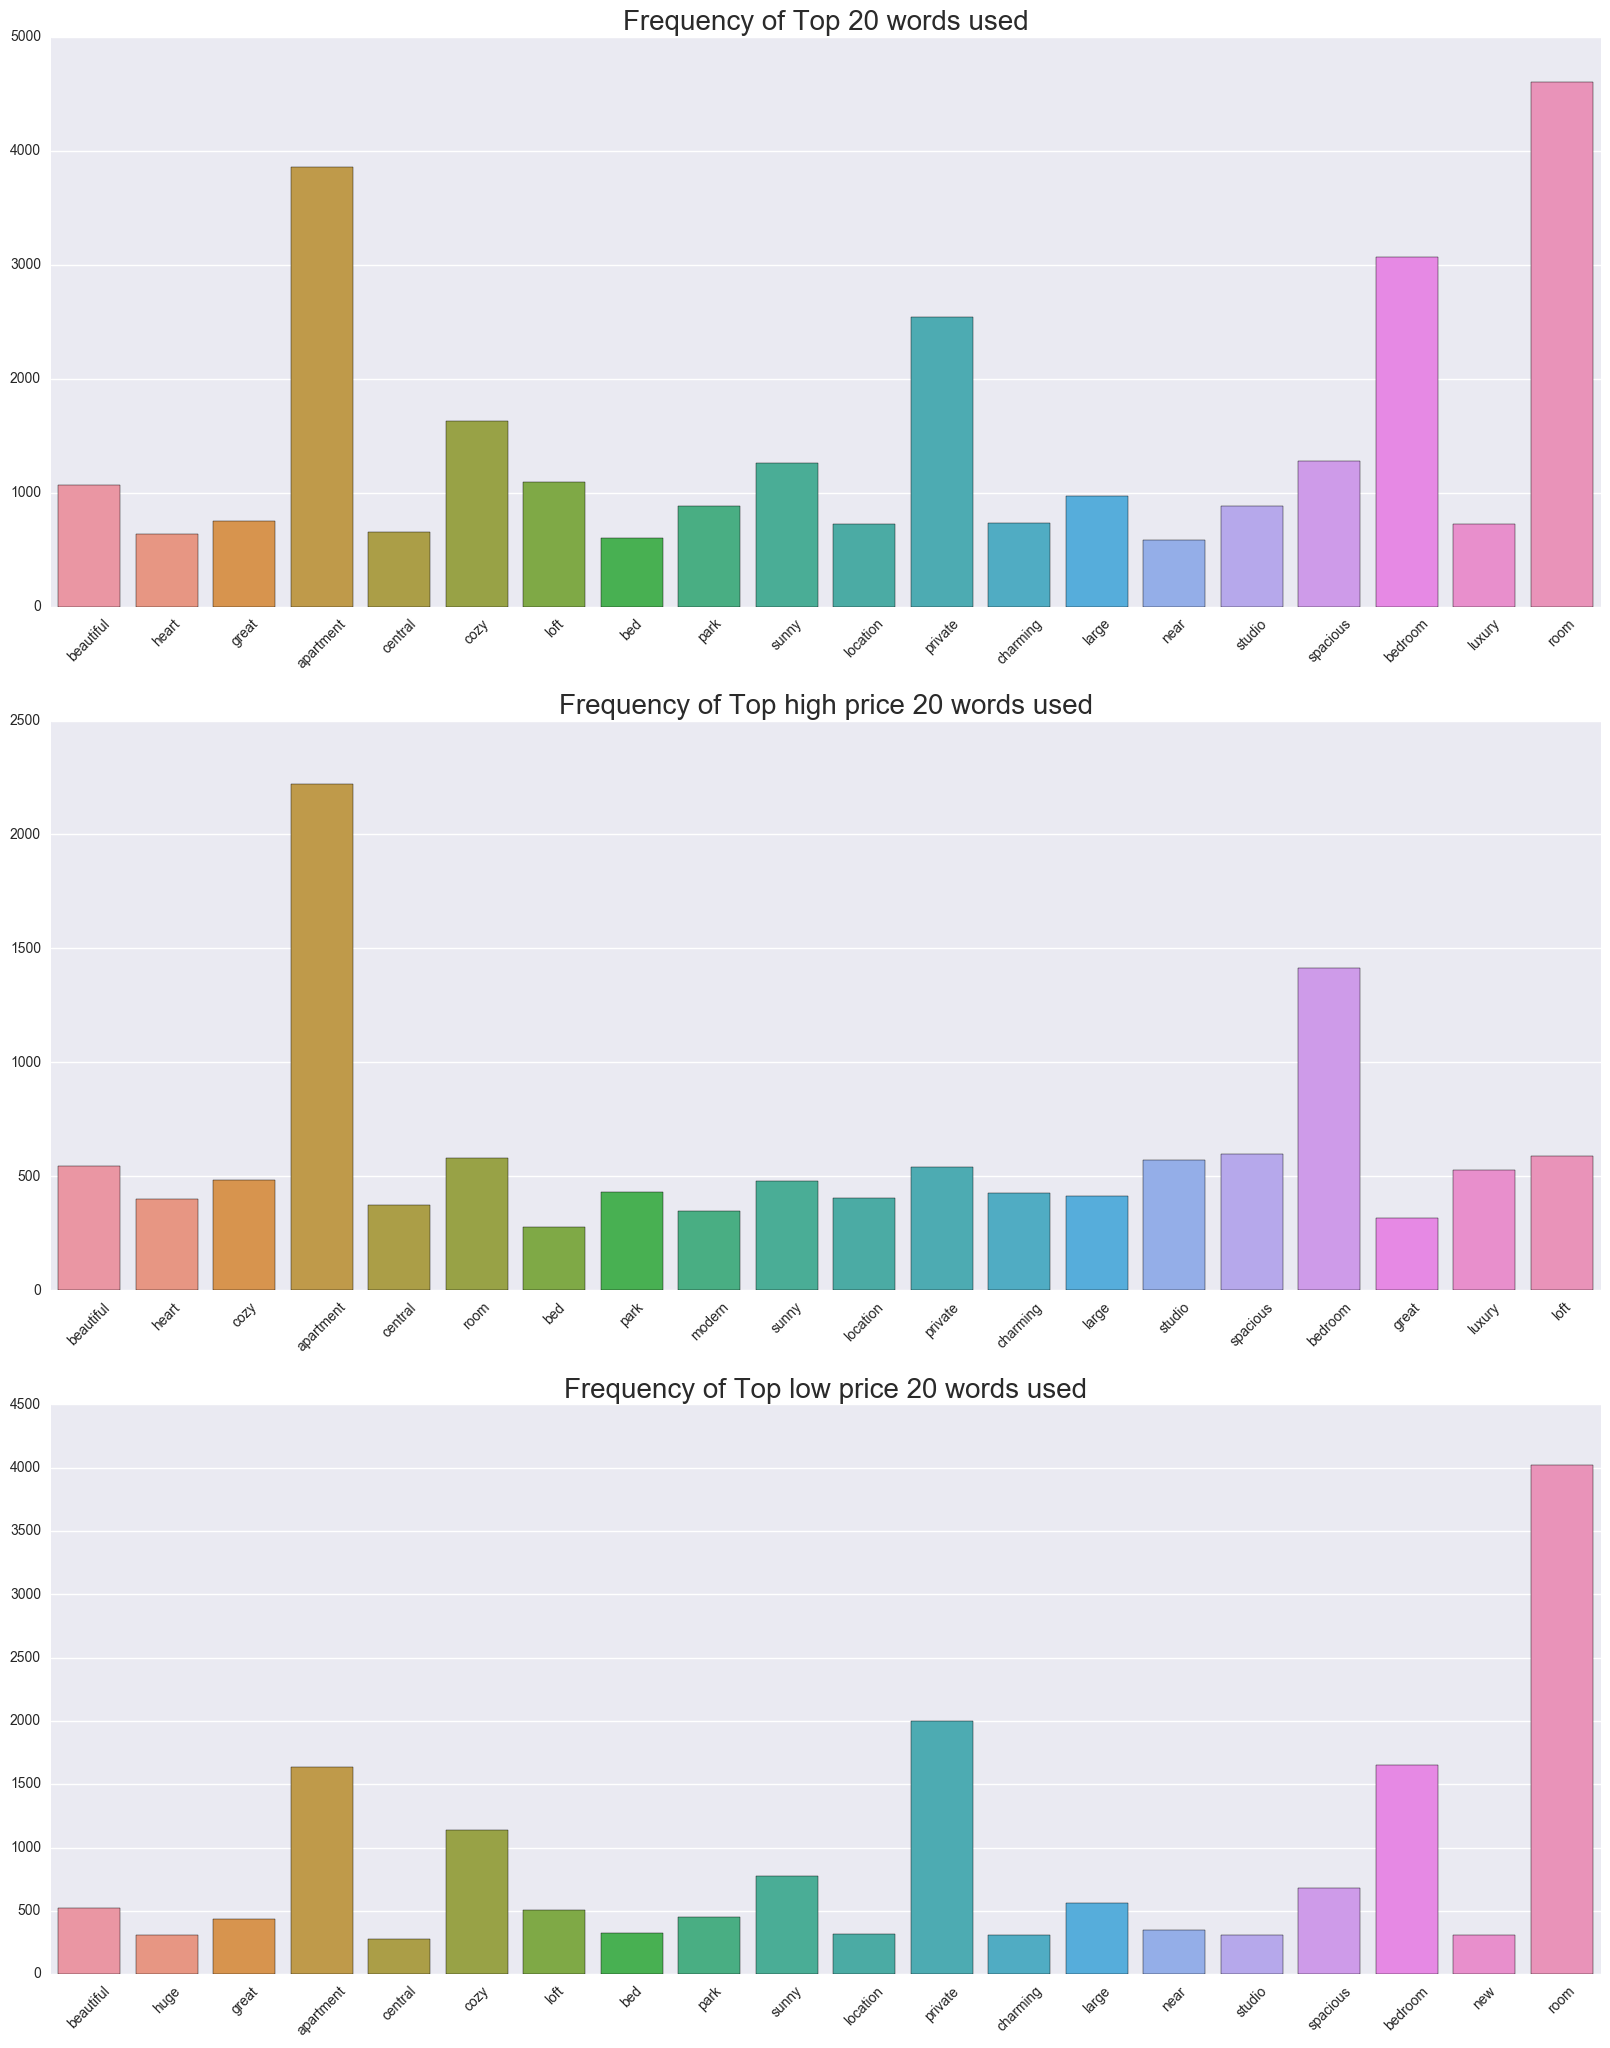

In [324]:
# plot the bar graph for top 20 occuring words  for full,pos ,neg dataset 
fig = plt.figure(figsize=(20,25))

#fig = plt.figure(figsize=(15,8))
wordsdict = {}
wordsdict_pos = {}
wordsdict_neg = {}
# Pick top 10 words from sorted list 
for w,wpos,wneg in zip(word_list[0:20],word_list_pos[0:20] ,word_list_neg[0:20])  :
# create a dictionary 
    wordsdict[w[0]] = w[1]
   
    wordsdict_pos[wpos[0]] = wpos[1]
    
    wordsdict_neg[wneg[0]] = wneg[1]

ax1 = fig.add_subplot(311)   
    
# plot the graph
#ax1.bar(range(len(wordsdict)), wordsdict.values(), align='center')
ax1 = sns.barplot(range(len(wordsdict)), wordsdict.values())
ax1.set_xticks(range(len(wordsdict)))
ax1.set_xticklabels(wordsdict.keys(),rotation=45,alpha =1.0)
ax1.set_title( "Frequency of Top 20 words used" ,alpha =5.0 ,fontsize = 20)

ax2 = fig.add_subplot(312)   
    
# plot the graph
ax2= sns.barplot(range(len(wordsdict_pos)), wordsdict_pos.values())
ax2.set_xticks(range(len(wordsdict_pos)))
ax2.set_xticklabels(wordsdict_pos.keys(),rotation=45,alpha =1.0)
ax2.set_title( "Frequency of Top high price 20 words used",alpha =5.0 ,fontsize = 20)


ax3 = fig.add_subplot(313)   
    
# plot the graph
ax2= sns.barplot(range(len(wordsdict_neg)), wordsdict_neg.values())
ax3.set_xticks(range(len(wordsdict_neg)))
ax3.set_xticklabels(wordsdict_neg.keys(),rotation=45,alpha =1.0)
ax3.set_title( "Frequency of Top low price 20 words used" ,alpha =5.0,fontsize = 20)

plt.show()

As it was seen with intial exploration with the counts that most of the words are present in both the classes same point can be seen from the above graph. If these words are deleted from the datset also then other set of most frequent dataset also overlaps.

#### Baseline Model

Before creating a new model, we’ll build a baseline models as we did earlier: all high price, all low price, and random. We’ll use these baseline models to determine whether or not we can make predictions on the price category that beat our baselines.

In [332]:
# No. of training points
def sk_split(x,y):
    n = len(x)
    n_train = int(n * 2.0 / 3.0)

# Random 2/3rd train, remaining test
    perm = np.random.permutation(n)
    y_train = y[perm[0:n_train]]
    x_train = x[perm[0:n_train]]
    y_test = y[perm[n_train:]]
    x_test = x[perm[n_train:]]
    return x_train , x_test ,y_train ,y_test

In [333]:
# Spilt the data 
x_train , x_test , y_train , y_test  =  sk_split(x,y)

To assess the quality ofour model, we have  splitted  the data into a training set and a testing set, we define our model on the training set and use the testing set to test the accuracy of our predictions.

In [37]:
#Function for computing the accuracy a given model on the entire test set, the accuracy on class 0 in the test set
#and the accuracy on class 1
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])],
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [38]:
#A model that labels everything 1
class Pos_model(object):
    def predict(self, x):
        return np.array([1] * len(x))
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
#A model that labels everything 0
class Neg_model(object):
    def predict(self, x):
        return np.array([0] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)


#A model that randomly labels things
class Random_model(object):
    def predict(self, x):
        return np.random.randint(0, 2, len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

In [39]:
# call all the base models
pos_model = Pos_model()
pos_model_scores = score(pos_model, x_test, y_test)

neg_model = Neg_model()
neg_model_scores = score(neg_model, x_test, y_test)

random_model = Random_model()
random_model_scores = score(random_model, x_test, y_test)

In [33]:
#Score Dataframe
score_df = pd.DataFrame({'pos model': pos_model_scores,
                         'neg model': neg_model_scores,
                         'random model': random_model_scores})
score_df

,neg model,pos model,random model
overall accuracy,0.555078,0.444922,0.505915
accuracy on class 0,1.000000,0.000000,0.490728
accuracy on class 1,0.000000,1.000000,0.495511


**Build an Improved Model**

In [40]:
#Check all the classifiers to see which one is good
#Unweighted logistic regression
unweighted_logistic = LogReg()
unweighted_logistic.fit(x_train, y_train)

unweighted_log_scores = score(unweighted_logistic, x_test, y_test)



#Weighted logistic regression
weighted_logistic = LogReg(class_weight='balanced')
weighted_logistic.fit(x_train, y_train)

weighted_log_scores = score(weighted_logistic, x_test, y_test)


#LDA
lda = LDA()
lda.fit(x_train, y_train)

lda_scores = score(lda, x_test, y_test)


#QDA
qda = QDA()
qda.fit(x_train, y_train)

qda_scores = score(qda, x_test, y_test)


#Decision Tree
tree = DecisionTree(max_depth=6)
tree.fit(x_train, y_train)

tree_scores = score(tree, x_test, y_test)



#Random Forest
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)


rf_wt = RandomForestClassifier(class_weight='balanced')
rf_wt.fit(x_train, y_train)
rf_wt_scores = score(rf_wt, x_test, y_test)


#SVM
clfsvm = SVC(kernel ='linear')
clfsvm.fit(x_train, y_train)
svm_scores = score(clfsvm, x_test, y_test)

clfsvm_wt = SVC(kernel ='linear',class_weight='balanced')
clfsvm_wt.fit(x_train, y_train)
svmwt_scores = score(clfsvm_wt, x_test, y_test)


#Score Dataframe
score_df = pd.DataFrame({#'knn': knn_scores, 
                         'unweighted logistic': unweighted_log_scores,
                         'weighted logistic': weighted_log_scores,
                         'lda': lda_scores,
                         'qda': qda_scores,
                         'tree': tree_scores,
                         'rf': rf_scores,
                          'weighted rf': rf_wt_scores,
                         'svm': svm_scores,
                         'weighted svm':svmwt_scores
                         })
score_df

,lda,qda,rf,svm,tree,unweighted logistic,weighted logistic,weighted rf,weighted svm
overall accuracy,0.705638,0.495007,0.674604,0.712398,0.650945,0.714856,0.709940,0.678138,0.705485
accuracy on class 0,0.719505,0.184935,0.734401,0.694491,0.498595,0.729904,0.665261,0.727375,0.624789
accuracy on class 1,0.688919,0.868858,0.602508,0.733988,0.834632,0.696713,0.763809,0.618773,0.802779


After converting our posts into numerical arrays, we trained different classifier  models using our data. From above we can see that logistic and SVM has done better than other models . The performance of SVM is slightly better than logistic model so lets tune the  SVM model and see the performance.



Cross Validation
The SVM classifier  accepts a C hyperparameter as argument. This parameter quantifies the regularization strength. To find a good value, we can perform a grid search with the GridSearchCV class. It takes as input an estimator, and a dictionary of parameter values. This new estimator uses cross-validation to select the best parameter.

In [41]:
# Tune the parmaters  
clfSVM = SVC(kernel = 'linear')
param_grid = {'C':[0.5,0.6,0.7,0.8,0.9,1.0]}
gridSvc = gs.GridSearchCV(clfSVM, param_grid=param_grid,n_jobs=10)
gridSvc.fit(x,y);
gridSvc.best_params_

{'C': 0.6}

In [319]:
#cv.cross_val_score(grid.best_estimator_, X, y)
scores = cross_val_score( clfSVM, x_train, y_train)
print  scores 
print  scores.mean()
    

[ 0.70576037  0.70730583  0.70792992]
0.706998707041


In [334]:
# Run the best estimator to  check score on test and train 
clfSVM = SVC(kernel = 'linear',C=0.6)
clfSVM.fit(x_train, y_train)
# score on test and train
score_train = clfSVM.score(x_train,y_train)
Score_test = clfSVM.score(x_test,y_test)
Score_test_0 = clfSVM.score(x_test[y_test==0], y_test[y_test==0])
Score_test_1 = clfSVM.score(x_test[y_test==1], y_test[y_test==1])

# Print the Scores
print "Train Score:",score_train
print "Test Score:",Score_test
print "Test Score for Class 0:", Score_test_0
print "Test Score for Class 1:", Score_test_1


Train Score: 0.749250979488
Test Score: 0.712090950991
Test Score for Class 0: 0.686137506987
Test Score for Class 1: 0.743773456158


In [335]:
# find the top 50 nad Low 50 coefficents 
top = np.argmax(clfSVM.coef_)
bot = np.argmin(clfSVM.coef_)
coef = clfSVM.coef_.T
# Pick top 50 and low 50 in thhe sorted list
top50 = heapq.nlargest(30, range(len(coef)), coef.take)
bot50 = heapq.nsmallest(30, range(len(coef)), coef.take)
#append the features names in list and print the list
top = []
bot = []
print "\nAssociated with High  Income:\n"
for each in top50:
    top.append(feature_name[each]) 
    print feature_name[each]
print "\nAssociated with Low Income:\n"
for each in bot50:
    bot.append(feature_name[each])
    print feature_name[each]


Associated with High  Income:

bowl
famous
mayor
superbowl
girls
museums
happy
nolita
chelsea
penn
designer
quality
terrace
junior
lofty
rate
village
elev
gramercy
noho
amenities
years
side
hotel
neat
executive
deluxe
december
ues
sanctuary

Associated with Low Income:

nu
lga
mins
castle
come
stuy
breakfast
train
room
subway
minutes
affordable
secret
share
de
budget
min
bedstuy
soha
deal
brooklyn
relax
privateroom
metro
ppl
queen
columbia
aug
gardens
hidden


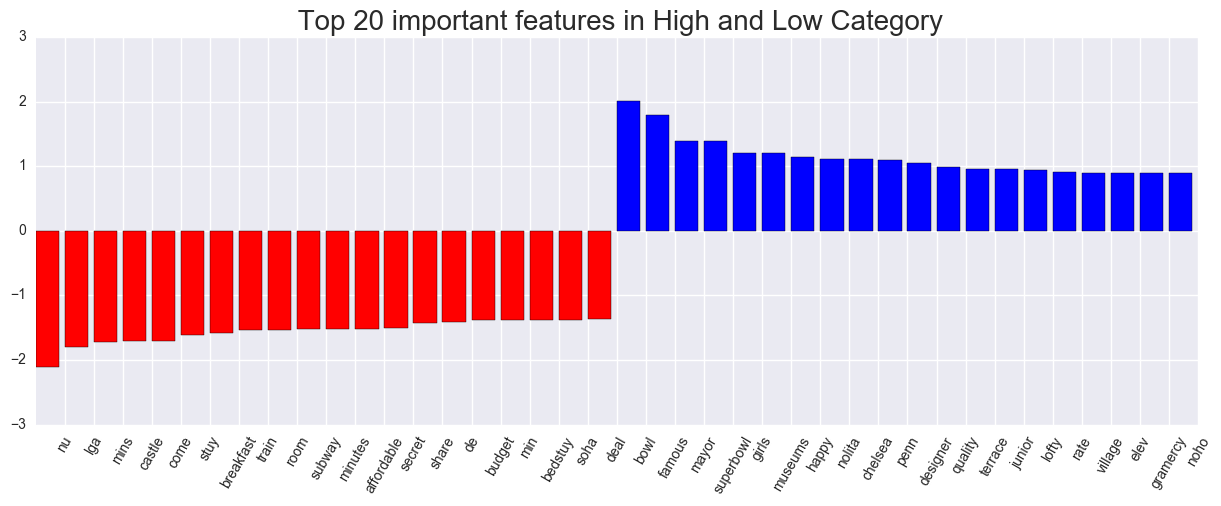

In [336]:
#plot the graph of 20 features in high and low income class
top_features =20
top_coefficients = np.hstack([bot50[:20], top50[:20]])
feature_list=[]
for each in top_coefficients:
    feature_list.append(feature_name[each]) 
  
 # create plot
plt.figure(figsize=(15, 5))
colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)

plt.xticks(np.arange(1, 1 + 2 * top_features),feature_list,rotation =60)
#plt.xticklabels(feature_list , rotation=60, ha='right')
#plt.xticks( feature_list , rotation=60, ha='right')
plt.title(" Top 20 important features in High and Low Category",alpha=5.0 ,fontsize = 20 )
plt.show()

In [269]:
# See the Count how many times the top 50 words occured in the high income list
df_high = df_list(x_pos, top)

df_high

,word,count
0,bowl,7
1,mayor,8
2,superbowl,4
3,nolita,21
4,chelsea,8
5,famous,27
6,us,14
7,uppereastside,218
8,church,13
9,amenities,10


In [337]:
# See the Count how many times the bot 50 words occured in the low income list
df_low= df_list(x_neg, bot)

df_low

,word,count
0,nu,14
1,lga,12
2,mins,22
3,castle,11
4,come,15
5,stuy,41
6,breakfast,12
7,train,36
8,room,7
9,subway,190


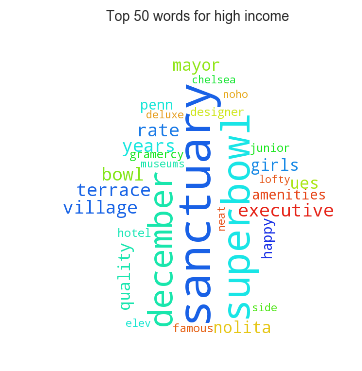

In [340]:
# Genearte Word cloud for high income 
#Get the text document
text = " ".join([each for each in top])
#Open the arrow image 

img_mask =  mpimg.imread("up_arrow.gif")
#Mask it with data
wordcloud = WordCloud(mask=img_mask,background_color="white").generate(text)

# Show the Word cloud 
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Top 50 words for low income',alpha =5.0,fontsize = 10 )
plt.show()

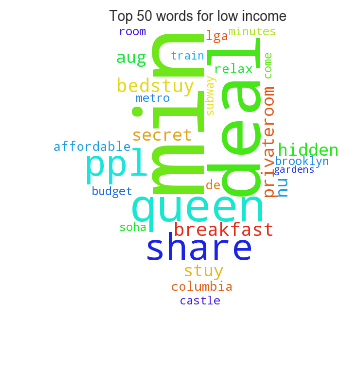

In [339]:
# Genearte Word cloud for low income 
#Get the text document
text_bot = " ".join([each for each in bot])
#Open the arrow image 

img_mask =  mpimg.imread("down_arrow.gif")
#Mask it with data
wordcloud = WordCloud(mask=img_mask,background_color="white").generate(text_bot)
# Show the Word cloud 
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Top 50 words for low income',alpha =5.0,fontsize = 10 )
plt.show()

I pulled off the words that my model showed were the most indicative of a high or low listing --i.e. the terms that had the strongest indication of whether a listing  would be high or low. These terms are listed above. Among the 50 high listing indicating terms,  I found generally high listing words in the English langauge like deluxe, grand, luxurious, executive, famous, quintessential. But I also found words more specific to the high listing ameneties: pool, baths, hotels and hi(hi-rise ,hi tech) and also the nearby location  to chelsea ,superbowl, nolita ,square (Time square), village(east),Carnegie Hill.  From these, we can infer that location nearby to famous area with ameneties like pool, bath  are listed with high price. 

Moreover, for low listing we can see the words like privateroom ,budget,deal,share which tend towards low price listing . Locations like lga ,soha ,brooklyn to any metro station ,subway ,train  are listed as low pricing. E Amenties like breakfast , room has been listed.
